In [4]:
import numpy as np
import pandas as pd
import sys,os
import alabtools.geo
from alabtools.analysis import HssFile
from scipy.spatial import distance
import networkx as nx
import markov_clustering as mc
import pickle
from scipy.spatial.distance import cdist
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [1]:
pip install networkx

  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install markov_clustering

Note: you may need to restart the kernel to use updated packages.


In [6]:
os.getcwd()

'/u/home/w/wyeast/IGM_tutorial'

#### Solution for the assignment

At individual structure level, in structure $m$, the distance of chromatin region $i$ to the nuclear center $d_{i,m}$ is 
$$
d_{i,m}=\frac{\sum_{c=0}^{K}{d_{c,i,m}}}{K}
$$
where $d_{i,c,m}$ is the distance of copy $c$ of region $i$ to the nuclear center, so d_{i,m} is the average of multiple copies of region $i$ to the nuclear center in structure $m$. For example, if genome is diploid
$$
d_{i,m}=\frac{d_{0,i,m}+d_{1,i,m}}{2}
$$
Because different cells have different nucleus shape, in order to make the radial position of a chromatin regions comparable within and across different cell. We use the normalized version of $d_{i,m}$:
$$
r_{i,m} = \frac{d_{i,m}}{R^{nuc}}
$$
where $R^{nuc}$ is the nucleus radius which is 5 μm for a sphere nucleus. $r_{i,m}$
= 0 means the region i is at the nuclear center while $r_{i,m}=1$ means it is located at the nuclear surface. 

### Mean radial position (RAD)

How can we measure the average radial position of a chromatin region $i$ across all the structures in the population? We define the mean radial position RAD
$$
RAD_{i} = \frac{\sum_{m=1}^{N}{r_{i,m}}}{N}
$$
Where $N$ is the total number of structures in the population

In [9]:
# Read in HSS file
hss = HssFile('igm-model_mcrb_2.5MB.hss', 'r')
# First, we need to know which beads that represent the diffrent copies belong to the same bin in genome
copy_index=hss.index.copy_index
print(copy_index)
print(len(copy_index))

{0: [0, 1100], 1: [1, 1101], 2: [2, 1102], 3: [3, 1103], 4: [4, 1104], 5: [5, 1105], 6: [6, 1106], 7: [7, 1107], 8: [8, 1108], 9: [9, 1109], 10: [10, 1110], 11: [11, 1111], 12: [12, 1112], 13: [13, 1113], 14: [14, 1114], 15: [15, 1115], 16: [16, 1116], 17: [17, 1117], 18: [18, 1118], 19: [19, 1119], 20: [20, 1120], 21: [21, 1121], 22: [22, 1122], 23: [23, 1123], 24: [24, 1124], 25: [25, 1125], 26: [26, 1126], 27: [27, 1127], 28: [28, 1128], 29: [29, 1129], 30: [30, 1130], 31: [31, 1131], 32: [32, 1132], 33: [33, 1133], 34: [34, 1134], 35: [35, 1135], 36: [36, 1136], 37: [37, 1137], 38: [38, 1138], 39: [39, 1139], 40: [40, 1140], 41: [41, 1141], 42: [42, 1142], 43: [43, 1143], 44: [44, 1144], 45: [45, 1145], 46: [46, 1146], 47: [47, 1147], 48: [48, 1148], 49: [49, 1149], 50: [50, 1150], 51: [51, 1151], 52: [52, 1152], 53: [53, 1153], 54: [54, 1154], 55: [55, 1155], 56: [56, 1156], 57: [57, 1157], 58: [58, 1158], 59: [59, 1159], 60: [60, 1160], 61: [61, 1161], 62: [62, 1162], 63: [63, 11

In [10]:
# get chromosome names, start and end positions of the bins
index = hss.index
index_chroms = index.chromstr
index_starts = index.start
index_ends = index.end

In [11]:
crds=hss.coordinates
# iterate keys over copy_index, and get the coordinates of the beads that belong to the same bin, 
# then get the average radials of the beads that belong to the same bin, write chr start end and average 
# radial to a file
for bin in copy_index:
    #get chr, start, end, of the bin
    bead_0=copy_index[bin][0]
    chr=index_chroms[bead_0]
    start=index_starts[bead_0]
    end=index_ends[bead_0]
    #get the radials of the beads that belong to the same bin
    radials = hss.getBeadRadialPositions(copy_index[bin], nucleusRadius=(3050, 2350, 2350))
    #write chr start end and average radial to a file
    with open('RAD.txt', 'a') as f:
        f.write(chr+'\t'+str(start)+'\t'+str(end)+'\t'+str(np.mean(radials))+'\n')
    f.close()

#### Variability of structual feature
Now we know each genomic loci (bin) has an average radial position (RAD) in nucleus. Apart from the "Mean" of feature, Is there any other type of information we can get from the structure?

We may use standard deviation to measure the disperson of radials for a particular bin $i$ in individual structures
$$
\sigma_i = \sqrt{\frac{1}{N}\frac{1}{K}\sum_{m=1}^{N}\sum_{c=0}^{K}(r_{c,i,m} - RAD_i)^2}
$$

In [12]:
#compute the std of the radials of the beads that belong to the same bin
for bin in copy_index:
    #get chr, start, end, of the bin
    bead_0=copy_index[bin][0]
    chr=index_chroms[bead_0]
    start=index_starts[bead_0]
    end=index_ends[bead_0]
    #get the radials of the beads that belong to the same bin
    radials = hss.getBeadRadialPositions(copy_index[bin], nucleusRadius=(3050, 2350, 2350))
    #write chr start end and average radial to a file
    with open('RAD_std.txt', 'a') as f:
        f.write(chr+'\t'+str(start)+'\t'+str(end)+'\t'+str(np.std(radials))+'\n')
    f.close()

Is it possible to make the result more intuitive? We can do it by normalizing the $\sigma_i$ by the mean of $\sigma_i$ across genome ($\sigma_g$). Furthermore, we may take a logarithmic scale to the result, thus a positive value would then indicate that $\sigma_i$ for particular region $i$ exceeds the average variability across all bins in the genome, vice versa.
$$
\sigma_g=\frac{\sum_{i=1}^{M}\sigma_i}{M}
$$
Where $M$ is the total number of regions (bins) across genome, which depends on bin resolution and genome size.
$$
\delta_i=\log_2{\frac{\sigma_i}{\sigma_g}}
$$

In [13]:
#first, we need compute the mean RAD across the genome
#read the radial_std.txt, which contains the std of radial of each bin
radial_std=pd.read_csv('RAD_std.txt', sep='\t', header=None)
#compute the mean RAD across the genome, which is the mean of the fourth column of the radial_std.txt
mean_radial_std=np.mean(radial_std[3])

#compute delta RAD of the bin
for bin in copy_index:
    #get chr, start, end, of the bin
    bead_0=copy_index[bin][0]
    chr=index_chroms[bead_0]
    start=index_starts[bead_0]
    end=index_ends[bead_0]
    #get the radials of the beads that belong to the same bin
    radials = hss.getBeadRadialPositions(copy_index[bin], nucleusRadius=(3050, 2350, 2350))
    #write chr start end and average radial to a file
    with open('deltaRAD.txt', 'a') as f:
        f.write(chr+'\t'+str(start)+'\t'+str(end)+'\t'+str(np.log2(np.std(radials)/mean_radial_std))+'\n')
    f.close()

In [17]:
data=pd.read_csv('RAD.txt',sep='\t',header=None)

In [18]:
data

,0,1,2,3
0,chr1,0,2500000,0.853921
1,chr1,2500000,5000000,0.753380
2,chr1,5000000,7500000,0.735403
3,chr1,7500000,10000000,0.740301
4,chr1,10000000,12500000,0.766870
...,...,...,...,...
3295,chr21,80000000,82500000,0.847267
3296,chr21,82500000,85000000,0.842753
3297,chr21,85000000,87500000,0.718912
3298,chr21,87500000,90000000,0.551213


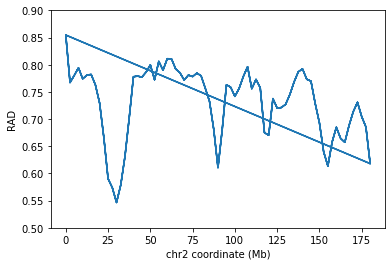

In [19]:
#plot the delta RAD for chr2
chr2=data[data[0]=='chr2']
chr2_coord=chr2[1]/1000000
chr2_radial=chr2[3]
plt.plot(chr2_coord,chr2_radial)
plt.xlabel('chr2 coordinate (Mb)')
plt.ylabel('RAD')
plt.ylim(0.5,0.9)
plt.show()

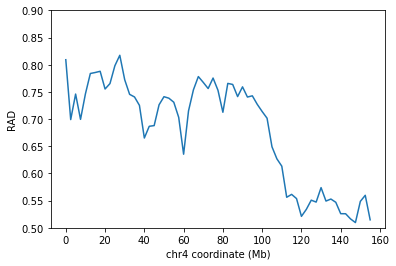

In [10]:
#What about chr4?
#plot the delta RAD for chr2
chr4=data[data[0]=='chr4']
chr4_coord=chr4[1]/1000000
chr4_radial=chr4[3]
plt.plot(chr4_coord,chr4_radial)
plt.xlabel('chr4 coordinate (Mb)')
plt.ylabel('RAD')
plt.ylim(0.5,0.9)
plt.show()

(0.5, 0.9)

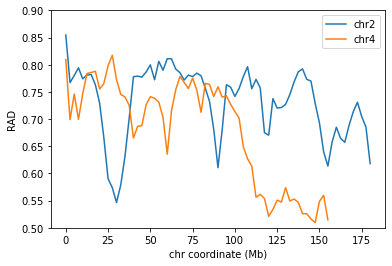

In [11]:
#We can plot chr2 and chr4 together
plt.plot(chr2_coord,chr2_radial,label='chr2')
plt.plot(chr4_coord,chr4_radial,label='chr4')
plt.xlabel('chr coordinate (Mb)')
plt.ylabel('RAD')
plt.legend()
plt.ylim(0.5,0.9)

In [12]:
import os
os.getcwd()

'/u/home/w/wyeast/IGM_tutorial'

### Practice
Can you plot the delta RAD for chr2 and chr4?

### Interior localization frequency (ILF)

For a given chromatin region $i$, the interior localization frequency (ILF) is calculated as:
$$
ILF_i=\frac{n_{r<0.5}}{N}
$$
where $ILF_i$ is the number of structures where either copy of the region $i$ has a radial position lower than 0.5, and $N$ is the total number of structures in our population. 0.5 is a empirical threshold of $RAD$, can be adjusted based on how you define a regions is within "interior" nucleus.

In [13]:

#compute ILF of the bin
for bin in copy_index:
    #get chr, start, end, of the bin
    bead_0=copy_index[bin][0]
    chr=index_chroms[bead_0]
    start=index_starts[bead_0]
    end=index_ends[bead_0]
    #get the radials of the beads that belong to the same bin
    radials = hss.getBeadRadialPositions(copy_index[bin], nucleusRadius=(3050, 2350, 2350))
    #get the boolean array showing if bead radial < 0.5
    interior_boolean=radials<0.5
    #we need to compute the ILF of the bin, and at least one bead belong to this bin has radial < 0.5
    new_array = np.any(interior_boolean, axis=0)
    ILF=np.sum(new_array)/new_array.size
    with open('ILF.txt', 'a') as f:
        f.write(chr+'\t'+str(start)+'\t'+str(end)+'\t'+str(ILF)+'\n')

Let's break it down and see what happens in each step

In [15]:

radials=np.array([[0.1,0.6,0.1,0.6],
 [0.1,0.1,0.1,0.6]])
interior_boolean=radials<0.5
interior_boolean


array([[ True, False,  True, False],
       [ True,  True,  True, False]])

### Question
Usually $ILF$ should be correlated to $RAD$. A region with small $RAD$ usually has large $ILF$. So why we need to come up with the concept of $ILF$? Can you come up with a senario where those two concept represent different aspects of a chromatin region?

### Exersice
Plot the $ILF$ and $RAD$ of chr2 at the same plot. Set the yscale as (0,0.9). What information can you get from this plot?

### Nuclear-body association frequencies (SAF, LAF, NAF)

For a given 200-kb genomic region $i$, the association frequency to nuclear bodies (SAF, LAF, and NAF for speckle,
1034 lamina, and nucleoli association frequencies, respectively) are calculated as:
$$
SAF (or LAF or NAF)_i=\frac{n_{d_i<d_t}+n_{d_{i^\prime}<d_t}}{2N}
$$
$N$ is the total number of structures in our population. $n_{d_i<d_t}$ and $n_{d_{i^\prime}<d_t}$ are the number of structures, in which region $i$ and its homologous copy $i^\prime$ have a distance to the nuclear body of interest (NB) smaller than the association threshold , $d_t$. The $d_t$ s are set to 500 nm, 0.2 $\times R_{nuc}$, and 1000 nm for SAF, LAF, and NAF, respectively.

### How to get the position of speckle, nucleolus and lamina?


For $SAF$ and $NAF$ calculations, we use the predicted speckle and nucleolus partitions
to calculate distances (see Identifying spatial partitions via Markov clustering). For $LAF$, we use the direct
distances of regions to the nuclear envelope. For all association frequency calculations, we calculate
distances from the surface of the region to the center-of-mass of the partition or to the surface of the nuclear envelope.


### Lamina association frequencies (LAF)

$LAF$ is easy to compute, since for a given genomic bin $i$, we only need to compute the fraction of beads whose radial are larger than the threshold (like 0.8 $R$)

In [16]:

#compute LAF of the bin
for bin in copy_index:
    #get chr, start, end, of the bin
    bead_0=copy_index[bin][0]
    chr=index_chroms[bead_0]
    start=index_starts[bead_0]
    end=index_ends[bead_0]
    #get the radials of the beads that belong to the same bin
    radials = hss.getBeadRadialPositions(copy_index[bin], nucleusRadius=(3050, 2350, 2350))
    #get the boolean array showing if bead radial > 0.8
    lamina_boolean=radials>0.8
    #compute LAF
    LAF=np.sum(lamina_boolean)/lamina_boolean.size
    with open('LAF.txt', 'a') as f:
        f.write(chr+'\t'+str(start)+'\t'+str(end)+'\t'+str(LAF)+'\n')

### Speckle association frequencies (SAF)

To compute $SAF$, first we need to predict the position of nuclear speckles. The way we do it is 
1. Identify Speckle-Related Regions:
First, you identify the genomic regions that are highly related to speckle. These regions might be detected through some statistical or biological analysis, mapping specific genomic features to speckles.
2. Markov Clustering (MC) Algorithm:
For a given chromatin structure, you apply the Markov Clustering algorithm to identify if the speckle-related regions tend to cluster together in that structure. These clusters are then defined as speckle partitions, or simply as speckles.
3. Calculate the SAF:
    To calculate the SAF for a specific genomic region, you:
    - a. Measure Distance: Determine the distance of the genomic region to the center of the nearest speckle.
    - b. Apply Threshold: Check if the distance is smaller than a predefined threshold.
    - c. Compute SAF: Calculate how many of these regions meet the threshold criteria among a population of structures. Finally, divide this number by 2N, where N is the total number of genomic regions.

In [34]:
# First we identify the genomic regions that related to speckle (since we don't have more experimental data to help us
# figure out the location of speckle (like TSA-seq), we simply use the interior regions ($RAD<0.5$) as the speckle regions)
#read the radial.txt, which contains the RAD of each bin
RAD=pd.read_csv('RAD.txt', sep='\t', header=None)
RAD[4]='OUT'
#set the bins with RAD<0.5 as interior bins, modify the 4th column of the dataframe as 'IN'
RAD.loc[RAD[3]<0.5,4]='IN'
RAD
#keep the column 0,1,2,4
interior=RAD[[0,1,2,4]]
#output the interior bins
interior.to_csv('interior.txt', sep='\t', header=None, index=None)

In [35]:
#Now we have the speckle regions, however it is haploid, we need to make it diploid, first we read the haploid speckle regions
interior_hap = pd.read_csv('interior.txt', sep='\t', header=None)[3].values.astype(str)

In [37]:
#define a function to adapt a haploid track to a multiploid index (include the case of diploid index)
def adapt_to_index(hap_track, index):
    """Given a haploid track, adapts it to the multi-ploid index.

    Args:
        hap_track (np.ndarray(nbead_hap)): haplotype track
        index (alabtools.utils.Index): index object
    Return:
        np.ndarray(nbeads): adapted track
    """
    multi_track = np.zeros(len(index), dtype=hap_track.dtype)
    for i in index.copy_index:
        # copy_index is a Dictionary, where:
        # - keys are haploid indices (0, 1, 2, ..., nbead_hap - 1)
        # - values are the multiploid indices for the corresponding haploid index
        # for examples {0: [0, 1000], 1: [1, 1001], ...}
        multi_track[index.copy_index[i]] = hap_track[i]
    return multi_track



In [ ]:
#can you recall what is index object? Let's see
print(len(index))
index.chrom

In [ ]:
#convert the haploid speckle tags to diploid speckle tags
interior_dip=adapt_to_index(interior_hap, index)
print(interior_hap)
print(len(interior_hap))
print(interior_dip)
print(len(interior_dip))

In [22]:
#use a dictionary to save the boolean array for each state
table = {}
AllStates = np.array(['IN'])

for s in AllStates:
    table[s] = interior_dip==s

table

{'IN': array([False, False, False, ..., False, False, False])}

Now let's do Markov clustering to compute speckle partitions for a single structure as an example

In [23]:

# The primairy goal of this tutorial is to identify the speckle associated regions that are in close proximity to each other in the 3D space of the nucleus.
# First we create a 2D boolean matrix 'dist_close' indicating which pairs of genomic regions are "closed enough".

# Extract the coordinates for the first structure from the 'crds' array
str_crd = crds[:, 0, :]

# Compute the Euclidean distance between all pairs of coordinates in 'str_crd'
dist = distance.cdist(str_crd, str_crd, 'euclidean')

# Compute the 'dcap' 2D array saving the thresholds of pair-wise distances, 
# Each value in this array is by taking the distance between radii, multiplied by 2
dcap = distance.cdist(hss.radii[:,None], -hss.radii[:,None]) * 2

# Create a 2D boolean matrix 'dist_close' indicating which pairs of genomic regions are "closed enough"
# "closed enough" means their distance are less than or equal to the correspoding 'dcap' value
dist_close = dist <= dcap

# Initialize a boolean matrix 'ms' with the same shape as 'dist_close', filled with False values
ms = np.zeros(dist_close.shape, dtype=bool)

# Then we create a 2D boolean array cellids indicating which pairs of genomic regions are both belong to "speckle".
cellids = table['IN'][None, :] & table['IN'][:, None]

# Now ms is a 2D boolean matrix indicating which pairs of genomic regions are both belong to "speckle" and "closed enough".
ms = dist_close & cellids

# Convert the boolean matrix 'ms' into a graph using NetworkX
G = nx.from_numpy_matrix(ms)

# Convert the graph 'G' into a sparse matrix representation using SciPy
matrix = nx.to_scipy_sparse_matrix(G)

# Run the Markov Clustering (MCL) algorithm on the sparse matrix with a specified inflation value of 1.4
result = mc.run_mcl(matrix, inflation=1.4)

# Retrieve the clusters from the MCL result and convert them into a NumPy array
clusters = np.array(mc.get_clusters(result))

clusters

array([(0,), (1,), (2,), ..., (2091,), (2092,), (2093,)], dtype=object)

In [24]:
#We may further filter the clusters to remove singletons:
clusters = clusters[np.array([len(c) > 1 for c in clusters])]
clusters

array([(404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 417, 418, 419, 420),
       (903, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1517, 1518, 1519, 1520, 2003, 2070, 2071, 2072),
       (970, 971, 972)], dtype=object)

In [26]:
#save the clusters
cs = open('speckle_clusters_struc_0.dat', 'wb')
pickle.dump(clusters, cs)
cs.close()

After we get speckle clusters, next it would be very easy to compute the distance to the nearest speckle for each genomic region in every structure. 

In [28]:
#compute the centroids of each cluster from str_crd
cluster_centroids = []
for cluster in clusters:
    cluster_centroid=np.mean(str_crd[np.array(cluster)],axis=0) #str_crd is the coordinates of structure 0
    cluster_centroids.append(cluster_centroid)
    
dist_to_spec = cdist(str_crd, cluster_centroids)

In [ ]:
# dist_to_spec shape is # (nbead, nspeckle), every row is a genomic region, and every column is the center of a speckle,
# each element represents the distance between the genomic region and the speckle center.
dist_to_spec

In [ ]:
#The smallest distance among each row is the distance to the nearest speckle
dist_to_nearest_spec=np.min(dist_to_spec,axis=1)
dist_to_nearest_spec #shape is (nbead,)

This the result for a single structure, once we have the result for all structure, we may use it to further compute $SpD$ and $SAF$. Use the same rationale we may compute nucleolus related features like $NuD$ and $NAF$

In [41]:
# To compute the SpD we need nearest speckle distances array for every structures, we cheating here to repeate the result for first structure for #nstruc times
nstruc=crds.shape[1]
dist_to_nearest_spec_all_struc=np.column_stack([dist_to_nearest_spec] * nstruc) # dist_to_nearest_spec_all_struc shape is (nbeads, nstruc)
#Then SpD is simply the mean of the dist_to_nearest_spec_all_struc over the columns
spd=np.mean(dist_to_nearest_spec_all_struc,axis=1) # spd shape is (nbeads,)
#output the spd to a file
spd_df = pd.DataFrame(spd)
spd_df.to_csv('SpD.txt', sep='\t', header=None, index=None)

### Predicted TSA-seq

To predict TSA-seq signals for speckle, nucleoli, and lamina for a given region $i$, we use the following equation:
$$
sig_i = \frac{1}{M}\sum_{m=1}^{M}\sum_{l=1}^{L}e^{-\alpha ||d_{il}||} 
$$

Where $M$ is the number of models, $L$ is the number of predicted speckle locations in structure $m$, $d_{il}$ is the distance between the region $i$ and the predicted nuclear body location $l$, and $\alpha$ is the estimated decay constant in the TSA-seq experiment

In [ ]:
# tsa_alpha is the estimated decay constant
tsa_alpha=0.004
# The TSA signal is then taken as a negative exponential of the distances to speckle previously computed
speckle_tsa = np.sum(np.exp(- tsa_alpha * dist_to_spec), axis=1)  # (nbead,)  CHECK SUM, MEAN OR MIN

After compute the TSA-seq signal we normalize it by the mean signal calculated from all regions in the genome

$$
predicted\;\;TSAseq\;\;signal_i = log (\frac{sig_i}{\overline{sig}})
$$

where $\overline{sig}$ is the mean signal calculated from all regions in the genome. The predicted signal is then averaged over two copies for each region

### Radius of gyration (RG) of chromatin fiber 

The local compaction of the chromatin fiber at the location of a given locus is estimated by the radius of gyration (RG) for a range centered at the locus (i.e. comprising +500kb up- and 500 kb downstream of the given locus). To estimate the RG values along an entire chromosome we use a sliding window approach over all chromatin regions in a chromosome.

The RG for a 1 Mb region centered at locus i in structure m, is calculated as:
$$
RG_{i,m} = \sum_{j=1}^{N}{d_{j}^2}
$$


where $N$ is the number of chromatin regions in the given window, and $d$, is the distance between the chromatin region $j$ to the center of mass of all chromatin regions in this window.

In [ ]:
 # initialize the gyration radius array
gyr = []
# define the window size, 5 means each window contains 5 beads
window = 5
# loop over the beads and calculate the gyration radius
for i in range(hss.nbead):
    # get start and end of the window
    s = i - int((window - 1) / 2)
    e = i + int((window - 1) / 2)
    # check if the window is out of the structure
    if s < 0 or e > hss.nbead - 1:
        gyr.append(np.nan)
        continue
    # check if the window is out of the chromosome
    if hss.index.chrom[s] != hss.index.chrom[e]:
        gyr.append(np.nan)
        continue
    # calculate the gyration radius
    gyr.append(alabtools.geo.RadiusOfGyration(str_crd[s:e, :], hss.radii[s:e]))


### Mean inter-chromosomal neighborhood probability (ICP)

For each target chromatin region $i$, we define the neighborhood ${j}$ if the center-to-center distances of regions  ${j}$ to the target region are smaller than 500 nm, which can be expressed as a set $n(i) = \{j: j\neq i, d_{ij} < 500nm\}$. Inter-chromosomal neighborhood probability (ICP) is then calculated as:

$$
ICP_I = \frac{1}{2M}\sum_{m=1}^{M}\sum_{l=1}^{2}\frac{n_{inter}(m,i)}{n_{inter}(m,i)+n_{intra}(m,i)}
$$

where $M$ is the number of structures, $n_{intra}(m,i)$ and $n_{inter}(m,i)$ are the number of intra- and inter- chromosomal regions in the set $n(i)$ in structure $m$ for haploid region $i$

In [ ]:
# Here is the code to compute icp for a single structure
dist_thresh=500 # distance threshold for proximity matrix
# Find the inter-chromosomal matrix (inter_ij = True if i and j are on different chromosomal alleles)
inter = hss.index.chrom[:, None] != hss.index.chrom[None, :]
# Get proximity matrix, whose shape is (nbead, nbead) 
prox = cdist(str_crd, str_crd, 'euclidean') < dist_thresh
# Set proximity matrix diagonal to False (bead is not in proximity with itself)
np.fill_diagonal(prox, False)
# Combine inter and prox matrices
inter_prox = np.logical_and(inter, prox)
# Get Inter-chromosomal contact ratio for a single structure
inter_ratio = np.sum(inter_prox, axis=1) / np.sum(prox, axis=1)

### Median trans A/B ratio (TransAB)

For each target chromatin region $i$, we define the trans neighborhood ${j}$ if the center-to-center distances of regions  ${j}$ to the target region are smaller than 500 nm, which can be expressed as a set $n^t(i) = \{j: chrom_j\neq chrom_i, d_{ij} < 500nm\}$. Trans A/B ratio is then calculated as:

$$
trans\;\;AB\;\;ratio_i=\frac{n_A^t}{n_A^t+n_B^t}
$$

where $n_A^t$ and $n_B^t$ are the number of trans A and B regions in the set $n^t(i)$ for haploid region $i$. The median of the trans A/B ratios for a region is then calculated from all the trans A/B ratios of the homologous copies of the region observed in all the structures of the population

In [ ]:
# Here is the code to compute transab for a single structure
# First we simulate the A/B compartment annotations for all genomic bins, 
# usually this annotation is read from a file that saves the haploid genome-wide A/B compartment annotations (need to be converted to diploid by adapt_to_index function)
ab=np.random.choice(['A', 'B'], size=len(str_crd))
# Then we compute the transab score for each genomic bin
# Get the Trans AB matrices
ab = adapt_to_index(ab, hss.index)  # adapt AB track to multi-ploid index
ab_vstack = np.vstack([ab] * len(ab))  # convert AB track to a vertical stack (attention: not symmetric!)
transA = np.logical_and(inter_prox, ab_vstack == 'A')
transB = np.logical_and(inter_prox, ab_vstack == 'B')

# Get TransAB ratio
transAB_ratio = np.sum(transA, axis=1) / (np.sum(transA, axis=1) + np.sum(transB, axis=1))


/u/home/w/wyeast/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [ ]:
ab_vstack

array([['A', 'B', 'B', ..., 'B', 'A', 'A'],
       ['A', 'B', 'B', ..., 'B', 'A', 'A'],
       ['A', 'B', 'B', ..., 'B', 'A', 'A'],
       ...,
       ['A', 'B', 'B', ..., 'B', 'A', 'A'],
       ['A', 'B', 'B', ..., 'B', 'A', 'A'],
       ['A', 'B', 'B', ..., 'B', 'A', 'A']], dtype='<U1')